In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import entropy
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from matplotlib.colors import hsv_to_rgb


In [2]:
data = []
labels = []
paths = []
file_name = []

target_size = (100, 100)

for sub_folder in os.listdir("Citra Daun Padi\\"):
    sub_folder_files = os.listdir(os.path.join("Citra Daun Padi\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Citra Daun Padi\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        img = cv.resize(img, target_size)

        data.append(img)
        
        labels.append(sub_folder)
        paths.append(img_path)
        file_name.append(filename)

data = np.array(data)
labels = np.array(labels)
paths = np.array(paths)

In [3]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	data_augmented.append(data[i])
	labels_augmented.append(labels[i])
	paths_augmented.append(paths[i])
	file_name_augmented.append(file_name[i])
	data_augmented.append(cv.rotate(data[i], cv.ROTATE_90_CLOCKWISE))
	labels_augmented.append(labels[i])
	paths_augmented.append(paths[i])
	file_name_augmented.append(file_name[i])

In [4]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  500
Data setelah augmentasi:  1000


### melakukan clasifikasi

In [5]:
# Mendefinisikan kategori penyakit padi
Categories = ['blast', 'blight', 'tungro']
flat_data_arr = []
target_arr = []
datadir = './hasil1'

# Memuat data citra dan label dari setiap kategori penyakit
for category in Categories:
    print(f'memuat... kategori: {category}')
    path = os.path.join(datadir, category)
    for img in os.listdir(path):
        img_array = imread(os.path.join(path, img))
        img_resized = resize(img_array, (150, 150, 3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(category))
    print(f'loaded category: {category} BERHASIL')

# Mengonversi data menjadi array numpy
flat_data = np.array(flat_data_arr)
target = np.array(target_arr)

memuat... kategori: blast
loaded category: blast BERHASIL
memuat... kategori: blight
loaded category: blight BERHASIL
memuat... kategori: tungro
loaded category: tungro BERHASIL


In [6]:
df = pd.DataFrame(flat_data)
df['Target'] = target
df.shape

(500, 67501)

In [7]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=77, stratify=y)

print("Jumlah Data Training:", x_train.shape[0])
print("Jumlah Data Testing:", x_test.shape[0])

Jumlah Data Training: 400
Jumlah Data Testing: 100


In [9]:
# Membuat dan melatih model Naive Bayes
nb_classifier = GaussianNB()
nb_classifier.fit(x_train, y_train)

GaussianNB()

In [10]:
y_pred = nb_classifier.predict(x_test)

In [11]:
accuracy = accuracy_score(y_pred, y_test)
print(f"The model is {accuracy*100}% accurate")
print(classification_report(y_test, y_pred, target_names=Categories))

The model is 56.00000000000001% accurate
              precision    recall  f1-score   support

       blast       0.49      0.68      0.57        40
      blight       0.71      0.61      0.66        44
      tungro       0.29      0.12      0.17        16

    accuracy                           0.56       100
   macro avg       0.50      0.47      0.47       100
weighted avg       0.55      0.56      0.54       100



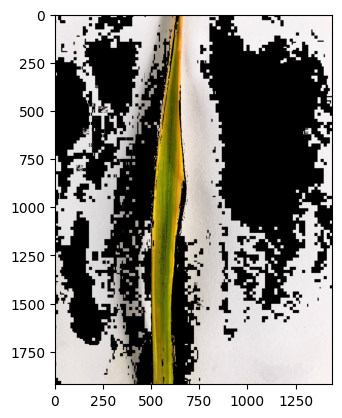

blast = 0.0%
blight = 100.0%
tungro = 0.0%
The predicted image is: blight


In [12]:
path = './hasil1/tungro/IMG_0400.jpg'
img = imread(path)
plt.imshow(img)
plt.show()
img_resize = resize(img, (150, 150, 3))
l = [img_resize.flatten()]
prediction = nb_classifier.predict(l)[0]
probability = nb_classifier.predict_proba(l)[0]

for ind, val in enumerate(Categories):
    print(f'{val} = {probability[ind]*100}%')

print("The predicted image is: " + Categories[prediction])

### Feature Extraction

In [13]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [14]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [15]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [16]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [17]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [18]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [19]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [20]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [21]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data_augmented)):
    D0 = glcm(data_augmented[i], 0)
    D45 = glcm(data_augmented[i], 45)
    D90 = glcm(data_augmented[i], 90)
    D135 = glcm(data_augmented[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [22]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [23]:
for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [24]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [25]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [26]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [27]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [28]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [29]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [30]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_sebelumprosesing.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_sebelumprosesing.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,IMG (119).jpg,blast,66.414545,62.094990,162.426162,267.047342,0.387039,0.358612,0.388570,0.327393,...,0.004201,0.003460,0.061998,0.059456,0.064817,0.058819,0.977803,0.979395,0.946134,0.911386
1,IMG (120).jpg,blast,162.426162,267.047342,66.414545,62.094990,0.388570,0.327393,0.387039,0.358612,...,0.003844,0.003535,0.064817,0.058819,0.061998,0.059456,0.946134,0.911386,0.977803,0.979395
2,IMG (121).jpg,blast,49.973333,127.093052,236.477980,362.163657,0.432595,0.401367,0.478295,0.401404,...,0.006657,0.005322,0.075532,0.072501,0.081591,0.072951,0.984661,0.961314,0.928021,0.889760
3,IMG (122).jpg,blast,236.477980,362.163657,49.973333,127.093052,0.478295,0.401404,0.432595,0.401367,...,0.005705,0.005256,0.081591,0.072951,0.075532,0.072501,0.928021,0.889760,0.984661,0.961314
4,IMG (123).jpg,blast,96.056667,25.439649,171.296162,360.480767,0.500319,0.470208,0.548683,0.454202,...,0.031424,0.023667,0.163604,0.155306,0.177269,0.153839,0.953926,0.987907,0.918542,0.828641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,IMG_0913.jpg,tungro,636.580101,598.576982,326.687677,943.923477,0.535209,0.529044,0.552338,0.517872,...,0.192081,0.180537,0.431880,0.426931,0.438271,0.424896,0.921947,0.926578,0.959772,0.884217
496,IMG_0916.jpg,tungro,27.113535,25.502806,77.005253,165.146822,0.446252,0.405145,0.366029,0.330733,...,0.034667,0.033361,0.190664,0.184874,0.186191,0.182651,0.995264,0.995538,0.986521,0.971107
497,IMG_0917.jpg,tungro,77.005253,165.146822,27.113535,25.502806,0.366029,0.330733,0.446252,0.405145,...,0.036353,0.034178,0.186191,0.182651,0.190664,0.184874,0.986521,0.971107,0.995264,0.995538
498,IMG_0923.jpg,tungro,10.303232,167.847567,156.777475,153.741761,0.479079,0.400983,0.440029,0.405997,...,0.011997,0.010621,0.104562,0.101695,0.109529,0.103060,0.998067,0.968686,0.970756,0.971318


### Features Selection

<Axes: >

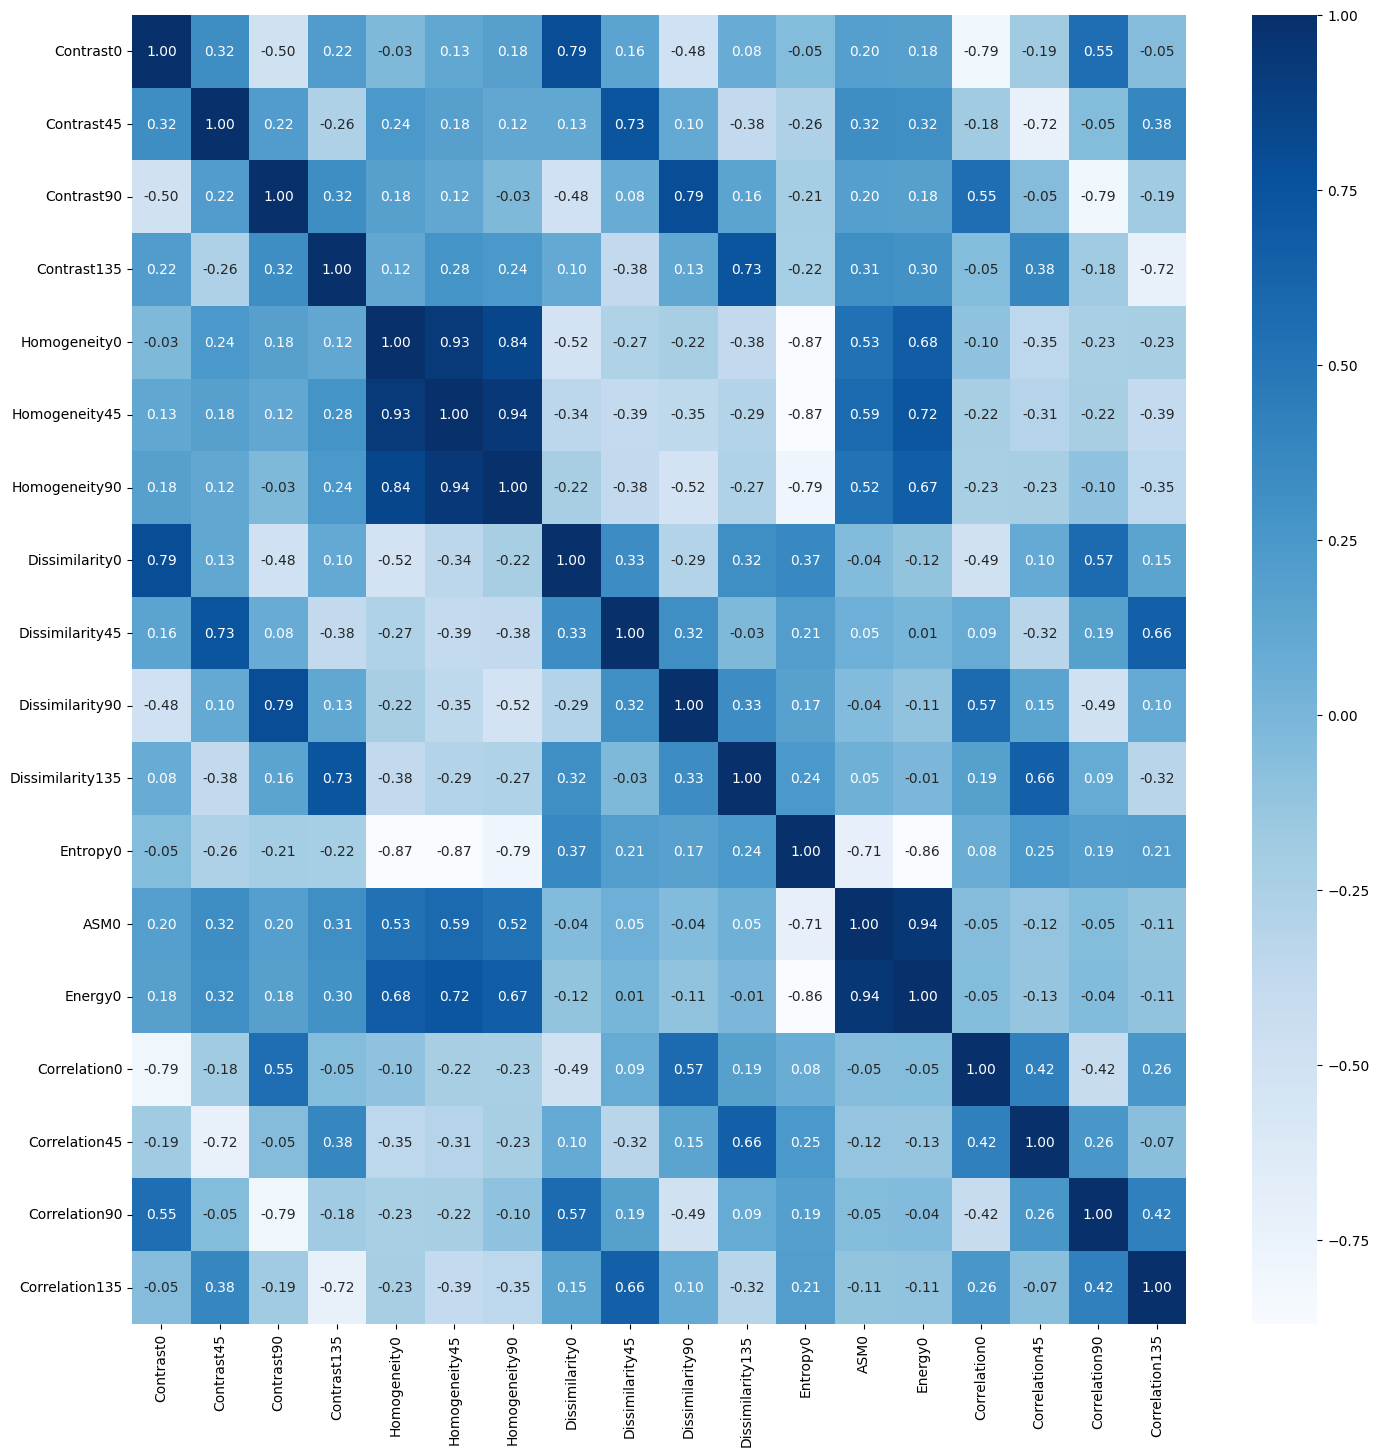

In [31]:
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

splitting data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train)
print(X_test)

      Contrast0  Contrast45  Contrast90  Contrast135  Homogeneity0  \
5    171.296162  360.480767   96.056667    25.439649      0.548683   
116   80.478586  255.913784  159.737677    62.342108      0.341414   
45   205.005859  382.276604   91.031919    58.110703      0.610227   
16    21.401111  198.315478  228.313636   259.180288      0.362369   
462   20.532424  117.191715  137.125354   161.990613      0.350848   
..          ...         ...         ...          ...           ...   
106   84.997778  282.772982  112.058283    13.150597      0.453979   
270  344.028384  376.872768   52.525960   346.574737      0.718035   
348  233.714848  249.858076   51.645455   229.102030      0.395193   
435  199.987071  203.173758    5.282828   200.375676      0.359946   
102  203.065960  111.873584   50.056162   302.948067      0.450317   

     Homogeneity45  Homogeneity90  Dissimilarity0  Dissimilarity45  \
5         0.454202       0.500319        3.682626         5.655545   
116       0.316573 

In [33]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [34]:
def crossValidation(x, y, model):
    y_pred = cross_val_predict(model, x, y, cv=20)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro', zero_division=1)
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')
    return y_pred, accuracy, precision, recall, f1


print("KNN")
y_pred_knn, akurasiKNN, presisiKNN, recallKNN, f1KNN = crossValidation(x_new, y, KNeighborsClassifier(n_neighbors=20))

print("\nRandom Forest")
y_pred_rforest, akurasiRForest, presisiRForest, recallRForest, f1RForest = crossValidation(x_new, y, RandomForestClassifier(n_estimators=175, random_state=50))

print("\nSVM")
y_pred_svm, akurasiSVM, presisiSVM, recallSVM, f1SVM = crossValidation(x_new, y, SVC(kernel='rbf', random_state=42))

KNN
Accuracy: 65.80%
Precision: 56.16%
Recall: 54.54%
F1 Score: 53.59%

Random Forest
Accuracy: 79.80%
Precision: 79.34%
Recall: 81.12%
F1 Score: 80.02%

SVM
Accuracy: 65.20%
Precision: 77.21%
Recall: 51.73%
F1 Score: 47.40%


evaluation

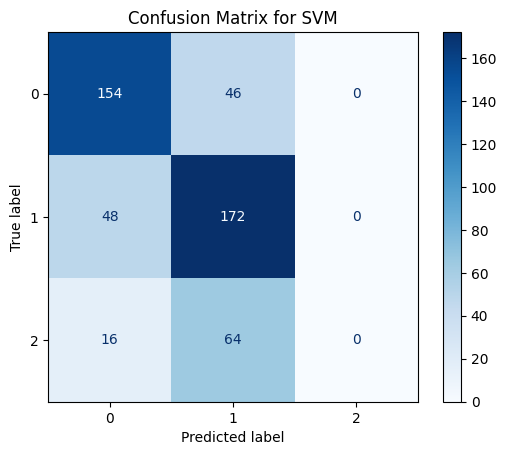

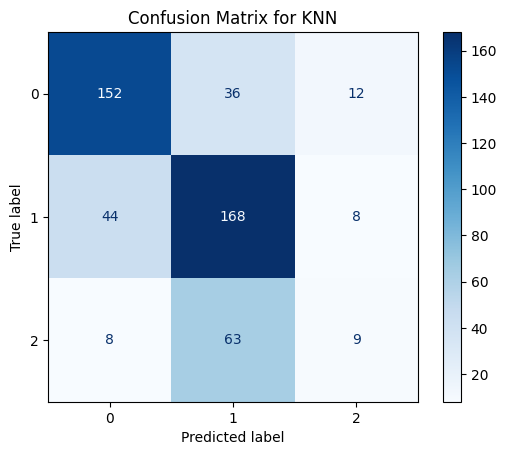

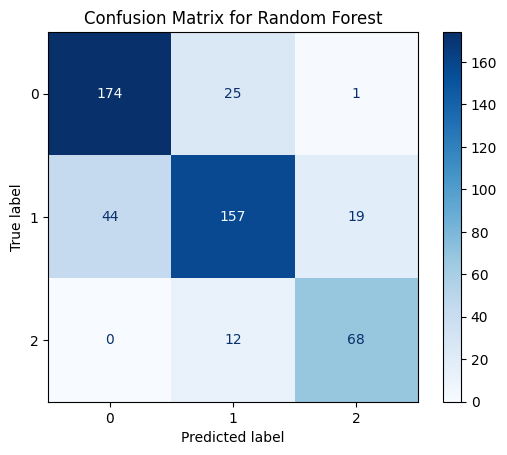

In [35]:
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y, y_pred_svm, 'Confusion Matrix for SVM')
plot_confusion_matrix(y, y_pred_knn, 'Confusion Matrix for KNN')
plot_confusion_matrix(y, y_pred_rforest, 'Confusion Matrix for Random Forest')